In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import nltk 

%matplotlib inline

from datasets import Dataset, load_dataset
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import accuracy_score, confusion_matrix

# Miscellaneous
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import re, string, unicodedata
from string import punctuation
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

/Users/oabas/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Collection and Exploration
We would be making use of 1 different datasets to train our model. 1 was gotten from the `Huggingface` dataset library while the other was gotten from `Kaggle`. Label Description:
0 : `Fake`, 1 : `Real`

## Noah-Gift Data

In [2]:
data_files = {"train": "news_articles.csv"}
dataset = load_dataset("noahgift/fake-news", data_files=data_files)

# Access the train and test split
train_data = dataset["train"]

# Convert the train split to a pandas DataFrame
df_noah = pd.DataFrame(train_data)

Found cached dataset csv (/Users/oabas/.cache/huggingface/datasets/noahgift___csv/noahgift--fake-news-62c59a179550f70c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 89.95it/s]


In [3]:
df_noah.head(3)

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0


In [4]:
df_noah_train = df_noah[['title_without_stopwords', 'text_without_stopwords', 'type', 'label']]

# Rename the 'type' column to 'subject'
df_noah_train = df_noah_train.rename(columns={'type': 'subject', 'text_without_stopwords': 'text', 'title_without_stopwords' : 'title'})

df_noah_train.head(2)

,title,text,subject,label
0,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,bias,Real
1,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,bias,Real


In [5]:
df_noah_train.shape

(2096, 4)

In [6]:
df_noah_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    2094 non-null   object
 1   text     2046 non-null   object
 2   subject  2095 non-null   object
 3   label    2095 non-null   object
dtypes: object(4)
memory usage: 65.6+ KB


In [7]:
# Checking for missing value
df_noah_train.isna().sum()

title       2
text       50
subject     1
label       1
dtype: int64

## Kaggle Dataset

In [8]:
# https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv

with zipfile.ZipFile("../Data/archive.zip", "r") as zip_ref:
    zip_ref.extractall("../Data/")

In [9]:
df_true = pd.read_csv("../Data/True.csv")
df_fake = pd.read_csv("../Data/Fake.csv")

In [10]:
df_true.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


In [11]:
# Adding A Target Class Column To Indicate Whether The News Is Real Or Fake
df_true['label'] = "Real"

In [12]:
df_fake.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


In [13]:
# Adding A Target Class Column To Indicate Whether The News Is Real Or Fake
df_fake['label'] = "Fake"

In [14]:
# Concatenating Real And Fake News
df_kaggle_train = pd.concat([df_true, df_fake]).reset_index(drop = True)

# dropping the 'date' column
df_kaggle_train.drop(columns = ['date'], inplace = True)

df_kaggle_train.head(2)

,title,text,subject,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,Real


In [15]:
df_kaggle_train.nunique()

title      38729
text       38646
subject        8
label          2
dtype: int64

In [16]:
df_kaggle_train.shape

(44898, 4)

## Concatenating both datasets

In [17]:
# Concatenating Real And Fake News
df_train = pd.concat([df_noah_train, df_kaggle_train]).reset_index(drop = True)

df_train.head(2)

,title,text,subject,label
0,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,bias,Real
1,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,bias,Real


In [18]:
df_train.shape

(46994, 4)

# Exploratory Data Analysis

In [19]:
df_train.head(2)

,title,text,subject,label
0,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,bias,Real
1,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,bias,Real


## Label

In [20]:
df_train['label'].value_counts()

Fake    24775
Real    22218
Name: label, dtype: int64

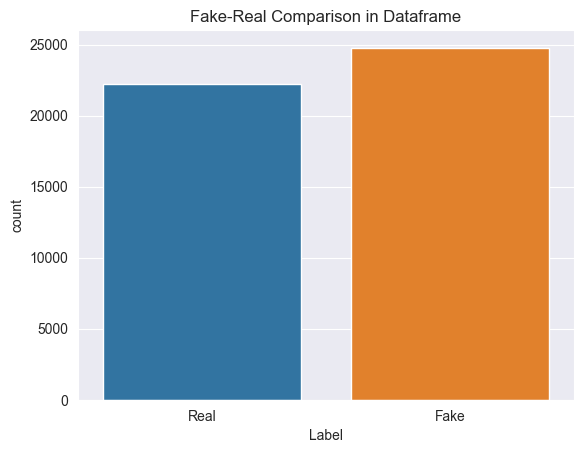

In [21]:
sns.set_style("darkgrid")
sns.countplot(x="label", data=df_train)

plt.title("Fake-Real Comparison in Dataframe")
plt.xlabel("Label")
plt.show()

## Subjects

In [22]:
df_train['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
bs                   601
bias                 436
conspiracy           430
hate                 244
satire               146
state                121
junksci              102
fake                  15
Name: subject, dtype: int64

In the context of your dataset, `bs`, `satire`, and `junksci` likely refer to the following:

1. `bs` is short for "bullshit", which is often used to describe misleading or false information.
2. `satire` refers to content that is intended to be humorous or mocking, often by using exaggeration or irony to make a point.
3. `junksci` is short for "junk science", which refers to information or research that is not based on sound scientific methods or principles.

Let's check for each thou

In [23]:
bs_data = df_train[df_train['subject'] == 'bs'][['title', 'text', 'label']]
bs_data.head()

,title,text,label
59,clinton prides pig farm bridge serco zulu serv...,rothschild banksters british voting machines r...,Fake
60,title,problem usa constitution states congress decla...,Fake
61,title,plenty proof machines rigged whic also means t...,Fake
62,title,trump excuse audit vote machines trust un invo...,Fake
63,title,got go one causing al trouble around worl proo...,Fake


In [24]:
bs_data = df_train[df_train['subject'] == 'junksci'][['title', 'text', 'label']]
bs_data.head()

,title,text,label
865,geniuses schizophrenics pass question quiz dav...,posted october michael depinto anyone heard ye...,Fake
866,pomegranate pistachio pancakes david avocado w...,posted october paul joseph watson authorities ...,Fake
1290,california becomes second state raise legal sm...,americas shrimp imports injected dangerous che...,Fake
1291,babies obese mothers high risk brain damage st...,superbugs big pharma blame coming death people...,Fake
1292,nestle launch new nongmo products shocked mons...,contaminated food china entering us organic la...,Fake


Also, we can see from the `subject` unique columns that we have `politics` and `politicsNews` which is the could be under the same context.

In [25]:
# Transforming the unmatching subjects to the same notation
df_train['subject'] = df_train['subject'].replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

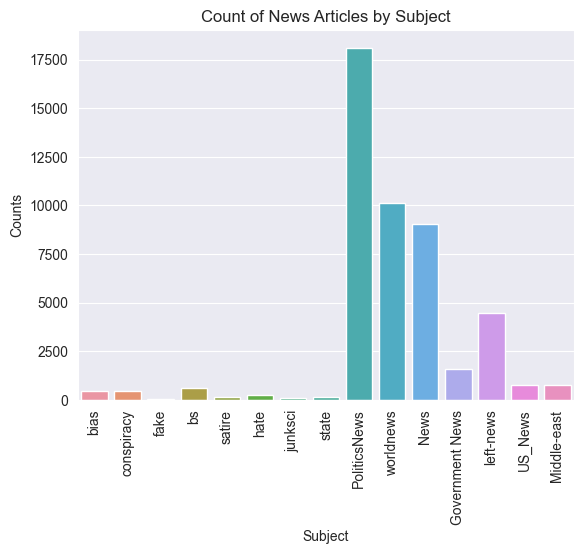

In [26]:
sns.set_style("darkgrid")
sns.countplot(x="subject", data=df_train)

plt.title("Count of News Articles by Subject")
plt.xlabel("Subject")
plt.xticks(rotation=90)
plt.ylabel("Counts")
plt.show()

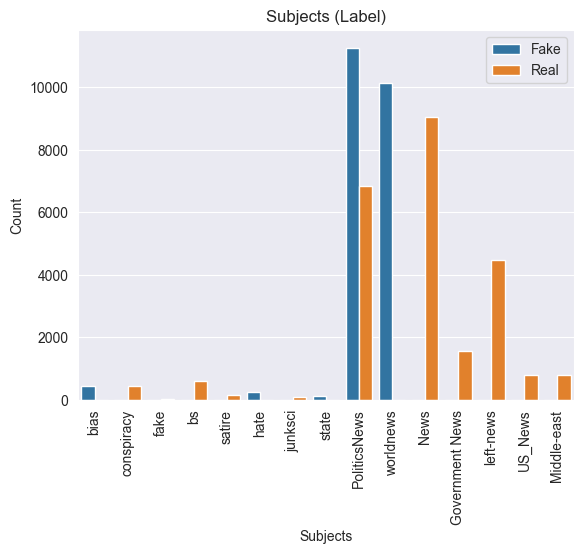

In [27]:
sns.countplot(x="subject", hue="label", data=df_train)

plt.title("Subjects (Label)")
plt.xlabel("Subjects")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake", "Real"], loc="best")
plt.show()

# Data Preprocessing

In [28]:
# Combining Title And Text Together
df_train['original'] = df_train['title'] + '. ' + df_train['text']
df_train.head()

,title,text,subject,label,original
0,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,bias,Real,muslims busted stole millions govt benefits. p...
1,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,bias,Real,attorney general loretta lynch plead fifth. at...
2,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,bias,Real,breaking weiner cooperating fbi hillary email ...
3,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,bias,Real,pin drop speech father daughter kidnapped kill...
4,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,bias,Real,fantastic trumps point plan reform healthcare ...


In [29]:
# Checking for duplicated in the news dataset
df_train.duplicated().sum()

270

In [30]:
# Dropping the duplicated in the news dataset
df_train.drop_duplicates(inplace=True)

In [31]:
# # Dropping columns not to be used
# df_train.drop(['title', 'text', 'subject'],axis=1,inplace=True)

# Checking for missing values
df_train.isna().sum()

title        2
text        33
subject      1
label        1
original    34
dtype: int64

In [32]:
# dropping missing columns
df_train.dropna(inplace=True)
df_train.shape

(46690, 5)

### Data Cleaning

In [33]:
# Obtaining Additional Stopwords From nltk
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

The `NLTK library` provides a predefined set of stop words that are commonly used in the English language. These stop words are usually common words that do not add much meaning to the text and are therefore removed during text preprocessing to reduce the size of the text corpus and improve the performance of the machine learning algorithm. However, sometimes, these predefined stop words may not be sufficient for a specific task that was why I decided to add additional stopwords to the list.

In [34]:
news = list(df_train['original'])
len(news)

46690

In [35]:
# Convert complaint data to lower case
news = [c.lower() for c in tqdm(news)]

100%|█████████████████████████████████| 46690/46690 [00:00<00:00, 160627.75it/s]


In [36]:
# Tokenize the text
tokens = [word_tokenize(c) for c in tqdm(news)]

100%|████████████████████████████████████| 46690/46690 [01:21<00:00, 572.50it/s]


In [37]:
# Remove Stop-words
tokens = [[word for word in t if word not in stop_words]
          for t in tqdm(tokens)]

100%|███████████████████████████████████| 46690/46690 [00:25<00:00, 1806.64it/s]


In [38]:
# Remove Punctuation marks
tokenizer = RegexpTokenizer(r'\w+')
tokens = [["".join(tokenizer.tokenize(word)) for word in t
           if len(tokenizer.tokenize(word)) > 0] for t in tqdm(tokens)]

100%|███████████████████████████████████| 46690/46690 [00:11<00:00, 3922.20it/s]


In [39]:
tokens[2100]

['house',
 'panel',
 'chair',
 'introduces',
 '81',
 'billion',
 'disaster',
 'aid',
 'bill',
 'washington',
 'reuters',
 'chairman',
 'us',
 'house',
 'representatives',
 'appropriations',
 'committee',
 'introduced',
 'bill',
 'monday',
 'provide',
 '81',
 'billion',
 'emergency',
 'aid',
 'recent',
 'hurricanes',
 'wildfires',
 'legislation',
 'includes',
 '276',
 'billion',
 'federal',
 'emergency',
 'management',
 'agency',
 '261',
 'billion',
 'community',
 'development',
 'block',
 'grants',
 'representative',
 'rodney',
 'frelinghuysen',
 'said',
 'statement',
 'president',
 'donald',
 'trump',
 'requested',
 '44',
 'billion',
 'last',
 'month',
 'widely',
 'criticized',
 'lawmakers',
 'insufficient']

In [40]:
df_train["clean_tokens"] = tokens

In [41]:
# Checking for unique tokens in the whole dataset
counter = Counter([t for news in tqdm(tokens) for t in news])

100%|██████████████████████████████████| 46690/46690 [00:00<00:00, 73625.06it/s]


In [42]:
counter.most_common(10)

[('trump', 145696),
 ('said', 131495),
 ('us', 70291),
 ('would', 57311),
 ('president', 54743),
 ('people', 43939),
 ('one', 38632),
 ('state', 34431),
 ('new', 34079),
 ('also', 32740)]

In [43]:
print(f"We have {len(counter.keys())} unique tokens in the dataset")

We have 231192 unique tokens in the dataset


In [44]:
clean_text = [" ".join(news) for news in tqdm(tokens)]

100%|█████████████████████████████████| 46690/46690 [00:00<00:00, 105186.86it/s]


In [45]:
clean_text[2100]

'house panel chair introduces 81 billion disaster aid bill washington reuters chairman us house representatives appropriations committee introduced bill monday provide 81 billion emergency aid recent hurricanes wildfires legislation includes 276 billion federal emergency management agency 261 billion community development block grants representative rodney frelinghuysen said statement president donald trump requested 44 billion last month widely criticized lawmakers insufficient'

In [46]:
# Joining The Words Into A String
df_train["clean_text"] = clean_text
df_train.head(2)

,title,text,subject,label,original,clean_tokens,clean_text
0,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,bias,Real,muslims busted stole millions govt benefits. p...,"[muslims, busted, stole, millions, govt, benef...",muslims busted stole millions govt benefits pr...
1,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,bias,Real,attorney general loretta lynch plead fifth. at...,"[attorney, general, loretta, lynch, plead, fif...",attorney general loretta lynch plead fifth att...


### Visualizing Cleaned Up Dataset

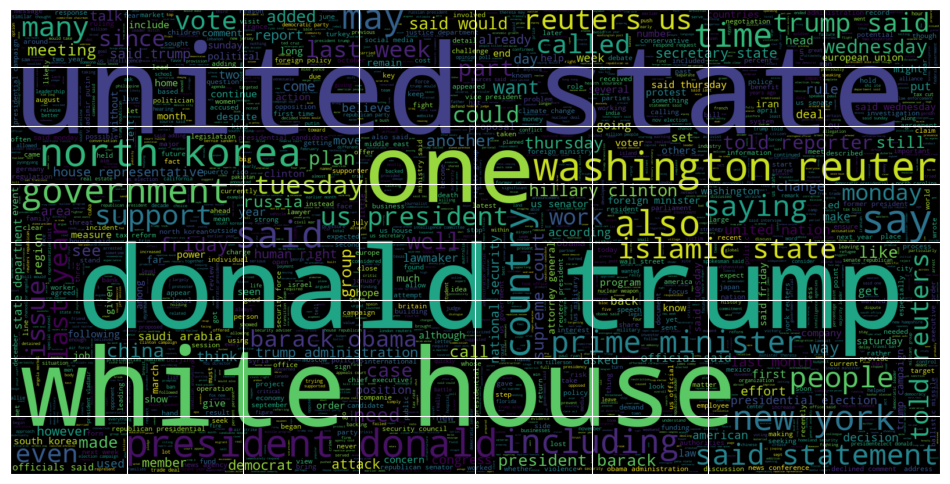

In [47]:
# Plotting The Word Cloud For Text That Is Real
plt.figure(figsize = (12,12))

wc = WordCloud(max_words = 2000,
               width = 1600,
               height = 800,
               stopwords = stop_words).generate(" ".join(df_train[df_train["label"] == "Real"].clean_text))

plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(wc, interpolation = "bilinear");

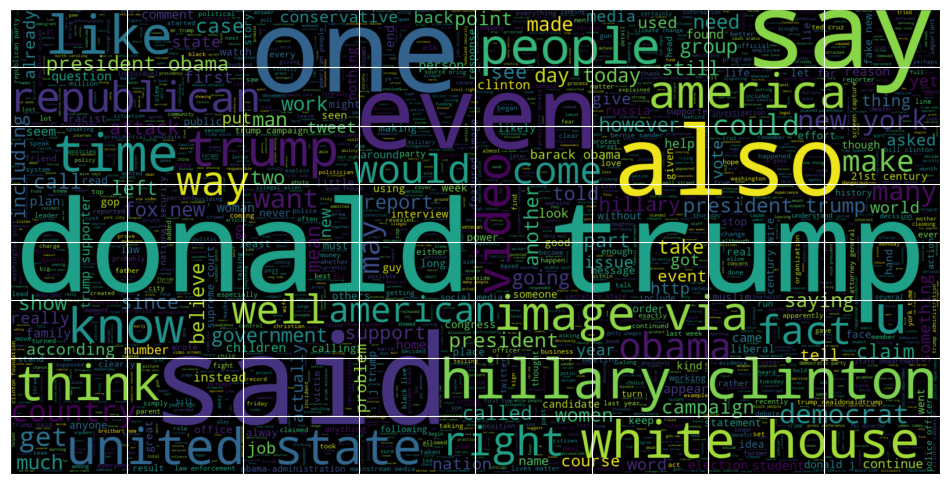

In [48]:
# Plotting The Word Cloud For Text That Is Fake
plt.figure(figsize = (12,12))

wc = WordCloud(max_words = 2000,
               width = 1600,
               height = 800,
               stopwords = stop_words).generate(" ".join(df_train[df_train["label"] == "Fake"].clean_text))

plt.tick_params(labelleft=False, labelbottom=False)
plt.imshow(wc, interpolation = "bilinear");

----